In [33]:
#imports
import requests
import pandas as pd
import xmltodict
import matplotlib.pyplot as plt
import numpy as np

In [4]:
#types
from dataclasses import dataclass

@dataclass
class Autor:
    CodigoParlamentar: str
    FormaTratamento: str
    NomeParlamentar: str
    UfParlamentar: str
    UrlPaginaParlamentar: str
    UrlFotoParlamentar: str
    QuantidadeMaterias: str

In [60]:
class ApiGetter:
    """
        Classe para fazer requests em APIs e tratar os erros de conexão
    """
    @staticmethod
    def get(url : str):
        try:
            response = requests.get(url)
            return response
        except requests.exceptions.RequestException as e:
            print(e)
            return None

class ApiXmlParser:
    """
        Classe para parsear xml de resposta de APIs, pois algumas respostas da API do senado vem em xml e outras json
    """
    @staticmethod
    def parse(xml : bytes):
        if xml is None:
            return None
        try:
            xml_decoded = xml.decode('ISO-8859-1')
            return xmltodict.parse(xml_decoded)
        except Exception as e:
            print(e)
            return None
    
class AutorMateriaAnalytics:
    """
        Classe para fazer análises sobre os autores de matérias legislativas
    """
    def __init__(self):
        self.api_response = ApiGetter.get("https://legis.senado.leg.br/dadosabertos/autor/lista/atual")
        self.parsed_response = ApiXmlParser.parse(self.api_response.content)
    
    def dataframe_autores(self):
        if self.parsed_response is None:
            return None
        try:
            autores = self.parsed_response['ListaAutores']['Autores']['Autor']
            df_autores = pd.DataFrame(autores, columns=['CodigoParlamentar', 'FormaTratamento', 'NomeParlamentar', 'QuantidadeMaterias'])
            df_autores['QuantidadeMaterias'] = pd.to_numeric(df_autores['QuantidadeMaterias'], errors='coerce')
            return df_autores
        except Exception as e:
            print(e)
            return None
    
    def autores_histogram(self, autores_types_list : list):
        """
            Plotar um histrograma dado uma lista de tipos dos autores de materias legislativas eg. ['deputado', 'senador', 'congressista']
        """
        
        df_autores = self.dataframe_autores()
        for autor_type in autores_types_list:
            current_df = None
            if autor_type == 'Congressistas':
                current_df = df_autores
            else:
                current_df = df_autores[df_autores['FormaTratamento'] == autor_type]
            counts, bins = np.histogram(current_df['QuantidadeMaterias'], bins=20)
            percentages = counts / counts.sum() * 100
            plt.figure(figsize=(20, 6))
            plt.text(0.95, 0.95, f'Total {autor_type.capitalize()}: {len(current_df)}', 
                    horizontalalignment='right', verticalalignment='top', 
                    transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
            plt.yticks(range(0, 500, 40))
            plt.xticks(range(0, 600, 20))
            current_df['QuantidadeMaterias'].plot(kind='hist', bins=20, edgecolor='black')
            for i in range(len(bins) - 1):
                if percentages[i] > 0:
                    plt.text(bins[i] + (bins[i + 1] - bins[i]) / 2, counts[i], f'{percentages[i]:.1f}%', ha='center', va='bottom')
            plt.title(f'Histograma do número de materias com relação à quantidade de {autor_type.capitalize()}')
            plt.xlabel('Quantidade de Materias Legislativas')
            plt.ylabel(f'Número de {autor_type.capitalize()}')
            plt.grid(True)
            plt.show()

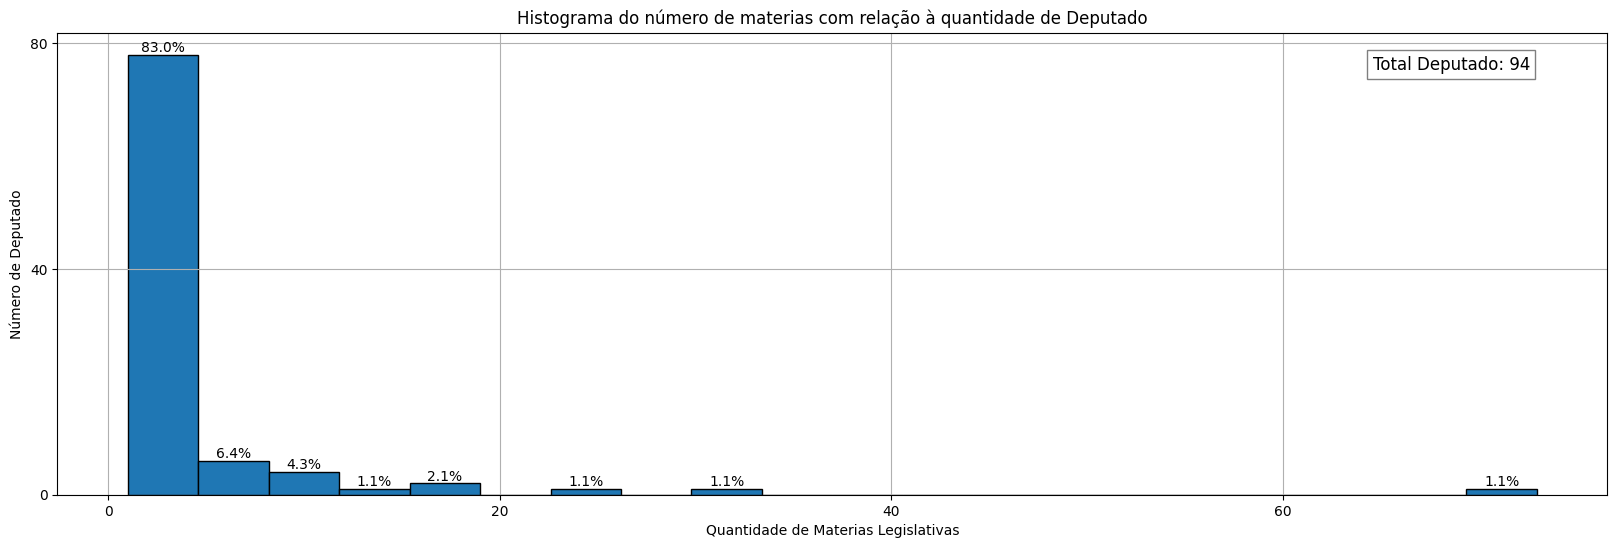

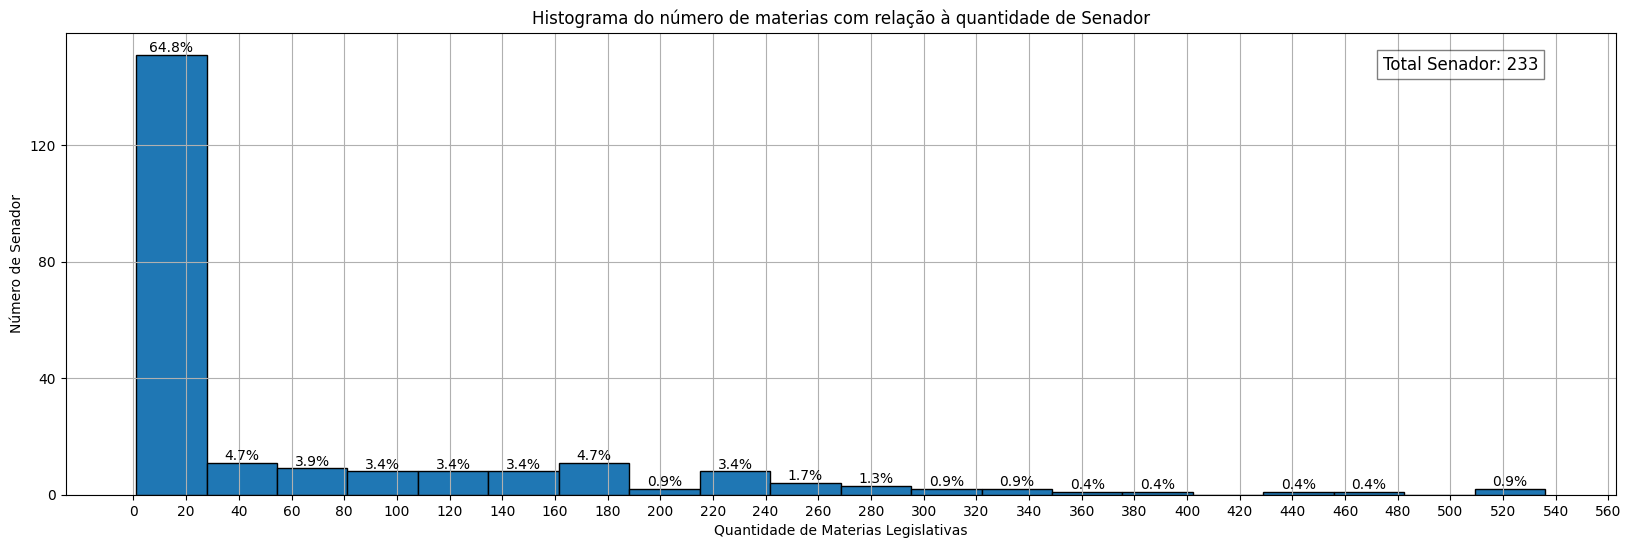

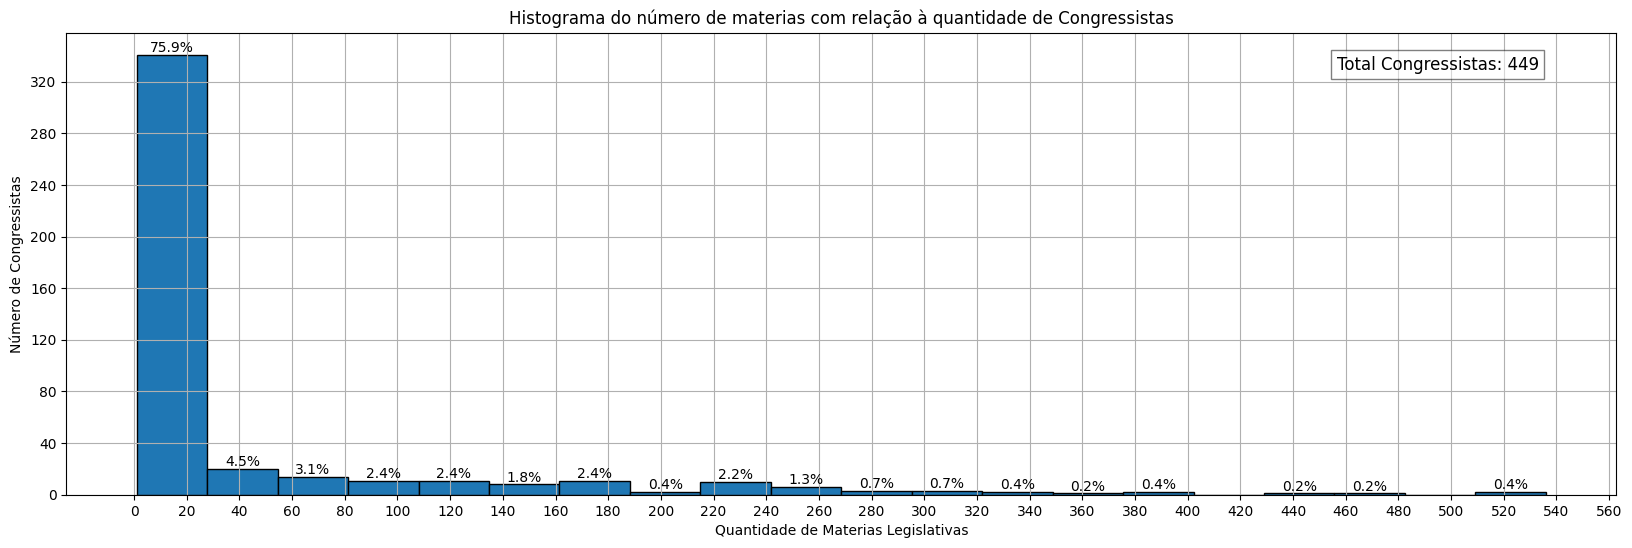

In [61]:
autor_analytics = AutorMateriaAnalytics()
autor_analytics.autores_histogram(['Deputado', 'Senador', 'Congressistas'])

In [ ]:
#dados sobre os congressistas
#afastados
url_afastados = "https://legis.senado.leg.br/dadosabertos/senador/lista/afastados"
url_
response_afastados = requests.get(url_afastados)